# Fastai image segmentation

In [1]:
from fastai.vision.all import *
torch.cuda.empty_cache()

In [2]:
path = untar_data(URLs.CAMVID)

In [3]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [4]:
valid_fnames[:4]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png']

In [5]:
path_im = path/'images'
lbl_names = path/'labels'

In [6]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(lbl_names)

<Axes: >

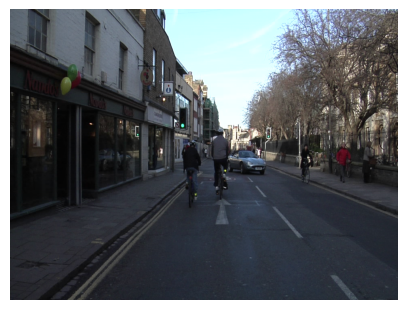

In [7]:
img_fn = fnames[9]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [8]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

<Axes: >

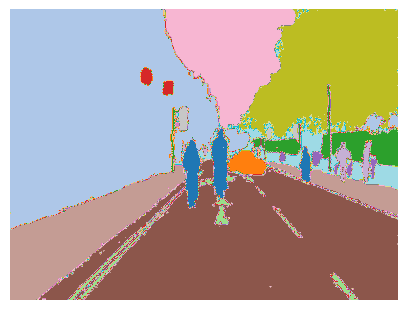

In [9]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:
def FileSplitter(fname):
    "Split the `items` depending on value of msk"
    valid = Path(fname).read_text().split()
    def _func(x): return x.name in valid
    def _inner(o,**kwargs): return FuncSplitter(_func)(o)
    return _inner
    

In [12]:
sz = msk.shape; sz

(720, 960)

In [15]:
quarter = tuple(int(x/4) for x in sz); quarter

(180, 240)

In [16]:
# Create DataLoader
# Use progressive resizing

def get_data(size,files_path,bs):
    sz = msk.shape
    dl = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                  get_items=get_image_files,
                  splitter=FileSplitter(path/'valid.txt'),
                  get_y=get_msk,
                  batch_tfms=[*aug_transforms(size=tuple(int(x/size) for x in sz),do_flip=True),
                             Normalize.from_stats(*imagenet_stats)])
    return dl.dataloaders(files_path, bs=bs)

In [17]:

camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                  get_items=get_image_files,
                  splitter=FileSplitter(path/'valid.txt'),
                  get_y=get_msk,
                  batch_tfms=[*aug_transforms(size=quarter),
                             Normalize.from_stats(*imagenet_stats)])

In [18]:
dls = camvid.dataloaders(path/'images', bs=8)

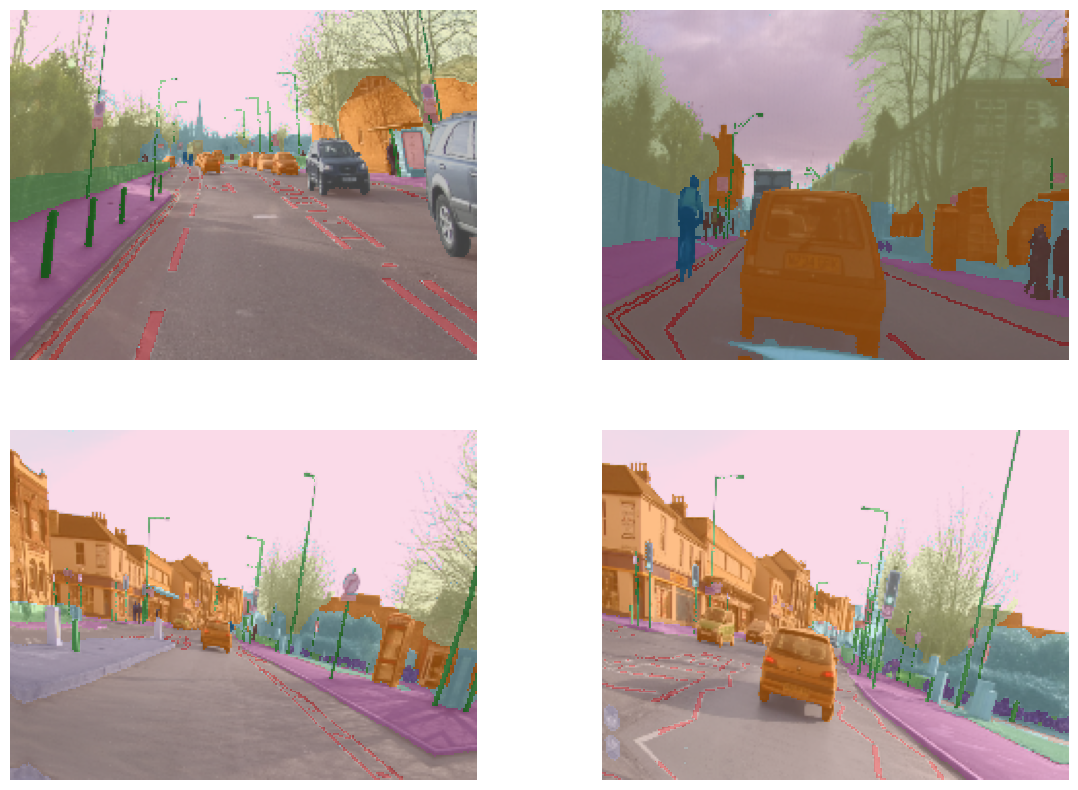

In [19]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [20]:
dls.vocab = codes

In [21]:
name2id = {v:k for k,v in enumerate(codes)}

In [22]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [23]:
void_code = name2id['Void']

In [24]:
def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [25]:
opt = ranger

In [26]:
path_im = path/'images';path_im

Path('/root/.fastai/data/camvid/images')

In [27]:
n = len(name2id.keys());n

32

In [28]:
n_classes = len(name2id.keys())
weights = torch.tensor([[1.1]+[0.9]*31]).cuda()
loss_func = CrossEntropyLossFlat(axis=1)

In [53]:
def train_unet(sizes, opt_func_name, bs):
    
    path_im = path/'images'
    print(path_im)
    for i,s in enumerate(sizes):
        print(s)
        if s==1:
            bs=1
        else: 
            bs=bs

        dls = get_data(s, path_im, bs=bs)
        dls.vocab = codes
        if s in [4]:
            epochs=12
        else:
            epochs=12
            
        if opt_func_name=="ranger":
            opt_func = ranger

            if i==0:
                learn = unet_learner(dls, resnet34, 
                                 metrics=acc_camvid, 
                                 self_attention=True, 
                                 act_cls=Mish, opt_func=opt_func, loss_func=loss_func)
                #learn.model=torch.nn.DataParallel(learn.model)
            else:
                learn.dls = dls

            if i==0:
                lr = learn.lr_find().valley*10
                learn.freeze()
                learn.fit_flat_cos(epochs, slice(lr))
                learn.unfreeze()
                lrs = slice(lr/400, lr/4)
                learn.fit_flat_cos(epochs, lrs)
            else:
                learn.fit_flat_cos(epochs, lrs)
            # learn.freeze()

        elif opt_func_name=="Adam":
            opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)

            learn = unet_learner(dls, resnet34, 
                             metrics=acc_camvid, 
                             self_attention=True, 
                             opt_func=opt_func, 
                             loss_func=loss_func,
                             norm_type=None, 
                             wd_bn_bias=True)
            #learn.model=torch.nn.DataParallel(learn.model)
            if i==0:
                lr = learn.lr_find().valley*10
                learn.freeze()
                learn.fit_one_cycle(epochs, slice(lr), pct_start=0.9, wd=1e-2)
                learn.unfreeze()
                lrs = slice(lr/400, lr/4)
                learn.fit_one_cycle(epochs, lrs, pct_start=0.7, wd=1e-2)
                learn.freeze()
                
            elif (i>0 and i<len(sizes)-1):
                learn.fit_one_cycle(epochs, slice(lr), pct_start=0.9, wd=1e-2)
                learn.unfreeze()
                lrs = slice(lr/400, lr/4)
                learn.fit_one_cycle(epochs, lrs, pct_start=0.8, wd=1e-2)
                learn.freeze()
                
                
            elif (i==len(sizes)-1):
                learn.fit_one_cycle(epochs, slice(lr), pct_start=0.9, wd=1e-2)
                learn.unfreeze()
                lrs = slice(lr/400, lr/4)
                learn.fit_one_cycle(epochs, lrs, pct_start=0.8, wd=1e-2)
                learn.freeze()

        learn.save('stage_'+str(i))
            
    

In [54]:
sizes = [2]
lr = 1e-3
bs = 8
# opt_func = ranger
opt_func = "Adam"

In [51]:
dls = get_data(2, path_im, bs=bs)
dls.vocab = codes
path_im = path/'images'
bs=8
opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)
learn = unet_learner(dls, resnet34, 
                    metrics=acc_camvid, 
                    self_attention=True, 
                    opt_func=opt_func, 
                    loss_func=loss_func,
                    norm_type=None, 
                    wd_bn_bias=True)
lr = learn.lr_find()

KeyboardInterrupt: 

In [49]:
lr

SuggestedLRs(valley=3.630780702224001e-05)

/root/.fastai/data/camvid/images
2


epoch,train_loss,valid_loss,acc_camvid,time
0,1.421458,0.986998,0.764830,01:40
1,0.946046,0.717963,0.831840,01:40
2,0.766953,0.591756,0.850139,01:40
3,0.666753,0.513854,0.859920,01:40
4,0.593514,0.472632,0.864528,01:40
5,0.566563,0.502829,0.872031,01:40
6,0.525682,0.465284,0.856375,01:40
7,0.512305,0.408732,0.885736,01:40
8,0.496239,0.363320,0.885938,01:39
9,0.460943,0.382474,0.888744,01:39


epoch,train_loss,valid_loss,acc_camvid,time
0,0.320516,0.280373,0.920030,01:43
1,0.315363,0.277234,0.921409,01:43
2,0.308664,0.271961,0.923413,01:43
3,0.304040,0.284249,0.918273,01:43
4,0.301288,0.280150,0.918542,01:43
5,0.291664,0.269455,0.922925,01:43
6,0.286228,0.284562,0.915676,01:43
7,0.276272,0.279268,0.919470,01:43
8,0.270458,0.284987,0.918265,01:43
9,0.256885,0.265516,0.924514,01:43


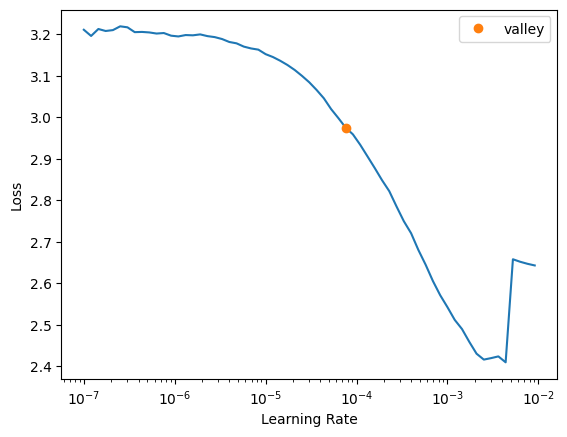

In [55]:
train_unet(sizes, opt_func, bs)

In [41]:
learn.summary()

DynamicUnet (Input shape: 8 x 3 x 180 x 240)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 90 x 120   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 45 x 60    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=9.120108734350652e-05)

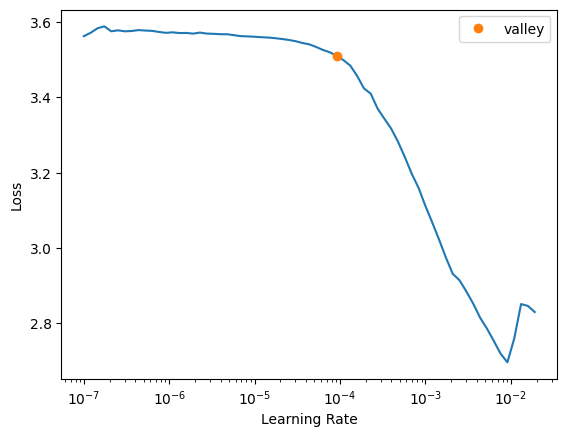

In [42]:
learn.lr_find()

In [43]:
lr = 1e-3

In [44]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.261629,0.805218,0.820785,00:31
1,0.796192,0.523874,0.852905,00:30
2,0.640644,0.512855,0.849871,00:30
3,0.550022,0.419539,0.877403,00:31
4,0.493704,0.405977,0.889456,00:30
5,0.469861,0.354665,0.899958,00:30
6,0.436244,0.359318,0.900364,00:30
7,0.404203,0.338144,0.903311,00:30
8,0.365813,0.315106,0.909210,00:30
9,0.327607,0.316033,0.908172,00:30


In [45]:
learn.save('full_1')

Path('models/full_1.pth')

In [46]:
learn.unfreeze()

In [48]:
lrs = slice(1e-6, lr/10); lrs

slice(1e-06, 0.0001, None)

In [49]:
learn.fit_flat_cos(10,lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.306052,0.305969,0.910893,00:32
1,0.298707,0.313524,0.909328,00:31
2,0.294540,0.314117,0.910280,00:31
3,0.295591,0.314822,0.909881,00:32
4,0.286456,0.302641,0.913273,00:31
5,0.285911,0.307641,0.911470,00:31
6,0.278739,0.318785,0.910385,00:31
7,0.275573,0.314326,0.910087,00:31
8,0.269413,0.309174,0.911039,00:31
9,0.265859,0.308879,0.912417,00:31


In [50]:
learn.save('full_2')

Path('models/full_2.pth')

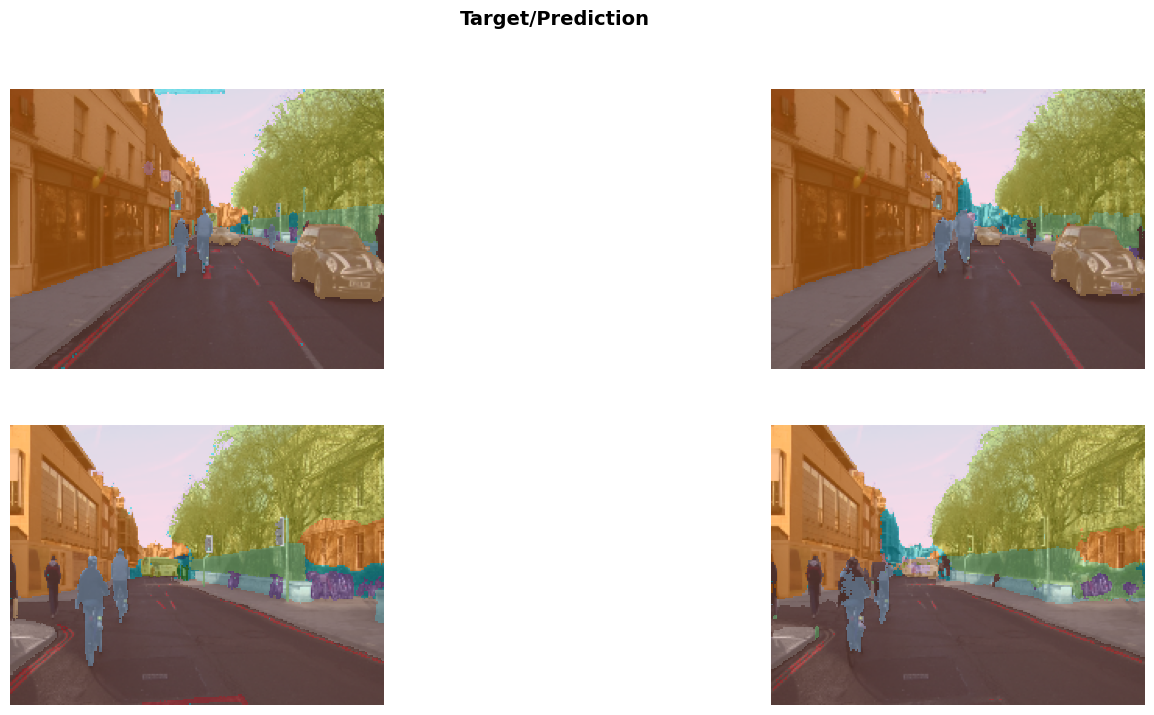

In [52]:
learn.show_results(max_n=2, figsize=(18,8))